# Car pricing

**Input data:** Frank Verboven's car dataset: https://sites.google.com/site/frankverbo/data-and-software/data-set-on-the-european-car-market

In [1]:
import pandas as pd 
import numpy as np 
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt

# various helper-files 
import cardata

This switch controls whether to use the nested logit model or the simple conditional logit. More on this later. 

In [2]:
NESTEDLOGIT = True

# Read in data

In [3]:
cars = pd.read_excel('cars.xlsx')

cars.sort_values(['ma', 'ye', 'co'], inplace=True)

cars.we = cars.we / 1000 # rescale from kg to tonnes: more sensible coefs. 

market_name        = ['Belgium','France','Germany','Italy','UK']; 
class_name         = ['subcompact','compact','intermediate','standard','luxury']; 
origin_code_name   = ['France','Germany','Italy','JapanKorea','Spain','Sweden','UK','EasternEurope','US','Brazil']; 
location_code_name = ['Belgium','CheckRepublic','France','Germany','Italy','Japan','Korea','Netherlands','Romania','Spain','Sweden','UK','Russia','Yugoslavia','Poland','US','Finland','Australia','Hungary','Portugal','India','Mexico']; 
firm_code_name     = {1: 'AlfaRomeo', 2: 'BMW', 3: 'Toyota', 4: 'Fiat', 5: 'Ford', 6: 'Honda', 7: 'Hyundai', 8: 'DeTomaso', 9: 'Kia', 10: 'Lada', 11: 'Mazda', 12: 'Mercedes', 13: 'Mitsubishi', 14: 'Nissan', 15: 'GeneralMotors', 16: 'Peugeot', 17: 'Porsche', 18: 'Renault', 19: 'Rover', 20: 'Saab', 21: 'Seat', 22: 'AZNP', 23: 'FujiHI', 24: 'Suzuki', 25: 'Toyota', 26: 'VW', 27: 'Volvo', 28: 'Yugo', 29: 'Daewoo', 30: 'Daimler', 31: 'DAF', 32: 'Jaguar', 33: 'TalbotSimcaHillmanSunbeam', 34: 'TalbotMatra', 42: 'Lancia'}

cars['market'] = cars['ma'].map({i+1:s for i,s in enumerate(market_name)}).astype('category')
cars['car_class'] = cars['cla'].map({i+1:s for i,s in enumerate(class_name)}).astype('category')
cars['firm'] = cars['frm'].map(firm_code_name).astype('category')
cars['firm_country'] = cars['org'].map({i+1:s for i,s in enumerate(origin_code_name)}).astype('category')
cars['firm_production'] = cars['loc'].map({i+1:s for i,s in enumerate(location_code_name)}).astype('category')

cars.sort_values(['ma', 'ye', 'qu'], ascending=False, inplace=True)

# Size of the market: this can have important bearings on the estimates. 
cars['pop'] = cars['pop']/10. # half are families, half are too young/too old, many do not consider a new car

# sales in class: relevant 
cars['sum_qu'] = cars.groupby(['ma', 'ye']).qu.transform('sum') # sold cars in this market-year 
cars['sum_qu_class'] = cars.groupby(['ma', 'ye', 'cla']).qu.transform('sum') # sold cars in market-year-class 
cars['num_in_class'] = cars.groupby(['ma', 'ye', 'cla']).qu.transform('count')
cars['market_share_of_class'] = cars['sum_qu_class'] / cars['sum_qu'] # share of sales to this class out of all sales
#cars['market_share_in_class'] = cars['qu'] / cars['sum_qu_class'] # share of sales in class that goes to this car 
cars['market_share_inside'] = cars['qu'] / cars['sum_qu'] # share of sales going to this car 
cars['market_share'] = cars['qu'] / cars['pop'] # share of the market buying this particular car 
cars['market_share_outside'] = 1.0 - cars['sum_qu'] / cars['pop'] # share of the market not buying a car 
cars['d_l_market_share'] = np.log(cars['market_share']) - np.log(cars['market_share_outside'])
cars['d_l_market_share_of_class'] = np.log(cars['market_share_of_class']) - np.log(cars['market_share_outside'])

# compute logarithms 
xvars = ['eurpr', 'we', 'hp', 'li']
zvars = [f'log_{x}' for x in xvars]
Nz = len(zvars)
for X in xvars: 
    cars[f'log_{X}'] = np.log(cars[X])
cars['logpr'] = np.log(cars['eurpr'])
cars['logqu'] = np.log(cars['qu'])

#cars['log_market_share_in_class'] = np.log(cars['market_share_in_class'])

Let's have a quick look at the data

In [4]:
cars.head(3)

,ye,ma,co,zcode,brd,type,brand,model,org,loc,...,market_share,market_share_outside,d_l_market_share,d_l_market_share_of_class,log_eurpr,log_we,log_hp,log_li,logpr,logqu
11536,99,5,936,80,8,ford focus,ford,focus,7,4,...,0.017737,0.680438,-3.647097,-0.704995,9.640695,0.067659,3.988984,2.001480,9.640695,11.544695
9687,99,5,70,82,8,ford fiesta,ford,fiesta,7,12,...,0.017153,0.680438,-3.680568,-0.691615,9.116581,-0.072571,3.761200,2.032525,9.116581,11.511224
10371,99,5,177,197,19,opel astra,opel,astra,7,12,...,0.015816,0.680438,-3.761705,-0.704995,9.560684,0.099845,3.988984,2.120263,9.560684,11.430087


A quick peak at the market shares of different brands across countries. 

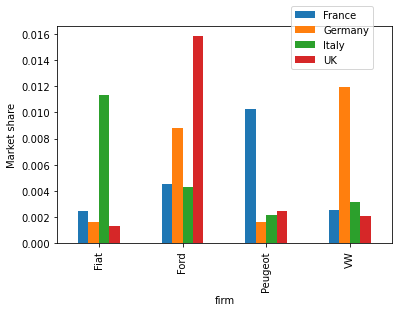

In [5]:
I = (cars.firm.isin(['VW', 'Fiat', 'Ford', 'Peugeot'])) & (cars.market.isin(['Germany', 'Italy', 'UK', 'France'])) 
ax = cars.loc[I].groupby(['firm', 'market']).market_share.mean().dropna().unstack().plot(kind='bar'); 
ax.legend(loc=(.7,.8)); 
ax.set_ylabel('Market share'); 
plt.savefig('img/marketshares.pdf'); 

# Estimation

## Logit

**Vanilla logit** models can be estimated by noting that the choice probabilities 
$$ \Pr(j) = \frac{\exp(v_{ij}) }{\sum_{k=0}^J \exp(v_{ik})} $$
implies that "log differences" cancel out the denominator: 
$$ \log \Pr(j) - \log \Pr(0) = v_{ij} - v_{i0} $$ 
Since we "observe" choice probabilities in the form of market shares, this suggests regressing log differences in market shares on characteristics (if we suppose that the outside option has $v_{i0} = 0$). 

## Nested logit

**Nested logit** The nested logit model allows for cars within the same "nest" to be closer substitutes than cars from different nests. For example, if the price increases on one subcompact, I may be more likely to switch towards a different subcompact than towards an SUV, if I was already considering a subcompact. This could be allowed by letting the `class` (compact, subcompact, SUV, etc.) of a car be the nest and estimating a nested logit. 

The nested logit choice probabilities take the form 
$$ \Pr(j) = \frac{
    \exp(v_{ij} / \rho) \left( \sum_{k \in L(j)} \exp( v_{ik}/\rho) \right)^{\rho-1}
        }{
        \sum_\ell \left(\sum_{k \in L_\ell} \exp(v_{ik}/\rho) \right)^\rho 
        }. $$
Fortunately, as we can see, this model can also be estimated by OLS. To see this, subtract $\log \Pr(0)$ from $\log \Pr(j)$, which gives 
$$ \log \Pr(j) - \log \Pr(0) = v_{ij} - v_{i0} + \log I[L(j)] - \log I[L(0)], $$
where 
$$ I[L_\ell] \equiv \left( \sum_{k \in L_\ell} \exp( v_{ik}/\rho) \right)^{\rho-1} $$ 
So that 
$$ \log I[L(j)] - \log I[L(0)] = \log \frac{\Pr(\text{nest }j)}{\Pr(\text{nest } 0)} $$

In [6]:
print_these = [z_ for z_ in zvars] 
if NESTEDLOGIT: 
    # include the market share of the class of the car as a regressor
    m = ols('d_l_market_share ~ log_eurpr + log_we + log_li + log_hp + d_l_market_share_of_class + C(frm) + C(ye) + C(ma)', 
        data=cars.reset_index())
    print_these = print_these + ['d_l_market_share_of_class']
else: 
    m = ols('d_l_market_share ~ log_eurpr + log_we + log_li + log_hp + C(frm) + C(ye) + C(ma)', 
        data=cars.reset_index())
res = m.fit()

#res.summary()
print(f'--- Parameter estimates (omitting fixed effects) ---')
res.params.loc[print_these]

--- Parameter estimates (omitting fixed effects) ---


log_eurpr                   -0.872476
log_we                       2.394577
log_hp                      -0.694630
log_li                      -1.139342
d_l_market_share_of_class    0.563120
dtype: float64

In [7]:
countries = np.sort(cars['ma'].unique())
years     = np.sort(cars['ye'].unique())
carcodes  = np.sort(cars['co'].unique())

T = len(years)
N = len(countries)
J = len(carcodes)

Extract coefficients on the car characteristics, $\hat{\beta}$. 

In [8]:
betahat = res.params.loc[zvars]

Extract $\hat{\xi}_{jti} \equiv \hat{\eta}_{\text{firm}(jti)} + \hat{\eta}_{t} + \hat{\eta}_i$, i.e. it is the sum of the fixed effects. 

In [9]:
xi = cardata.compute_xi_from_estimates(res, cars, fixed_effects=['frm', 'ye', 'ma'])

Year 70 not in coef
Market 1 not in coef


# From pandas to numpy

Converting from a pandas dataframe (where the # of rows per country varies) to a balanced matrix format, where all data objects are `J*T*N`. 

**Results** in the matrices `s` (for market **s**hares), and `z` (for car characteristics), and `available`. 

In [10]:
cars = cars.set_index(['ma', 'ye', 'co']).sort_index()

In [11]:
# matrix of market shares 
s = cardata.dataframe2matrix(cars, 'market_share', J,T,N)
available = np.isnan(s) == False

# matrix of car characteristics
z = np.nan * np.zeros((Nz, J, T, N))
for i,zvar in enumerate(zvars): 
    z[i, :,:,:] = cardata.dataframe2matrix(cars, zvar, J,T,N)

Print avg. values of car characteristics (always good to check they are not badly scaled)

In [12]:
zavg = np.nanmean(z.reshape(Nz, J*T*N), 1)
for i,zvar in enumerate(zvars): 
    print(f'{zvar: <10}: {zavg[i]: 8.4f}')

log_eurpr :   8.8239
log_we    :  -0.0481
log_hp    :   3.9580
log_li    :   2.0808


Useful to have a few neat variables in matrix form as well. In `cars`, they are in "unbalanced" form, so we transform them to the `J*T*N` matrices, which are in the logic of the logit model running in the background. 

In [13]:
firms    = cardata.dataframe2matrix(cars, 'firm', J, T, N)
carclass = cardata.dataframe2matrix(cars, 'cla' , J, T, N)
types    = cardata.dataframe2matrix(cars, 'type', J, T, N)

## Checking the fit of the model

In [14]:
cars.market_share_outside.mean()

0.679379642516885

In [15]:
betahat = res.params.loc[zvars] # use OLS estimatse 

In [16]:
probs = cardata.choice_prob(xi,z,betahat,available)

In [36]:
Pr_nocar = (1.0-probs.sum(0)).mean()
print(f'At chosen parameters, {Pr_nocar: .2%} choose no car. In the data: {cars.market_share_outside.mean():.2%}')

At chosen parameters,  99.98% choose no car. In the data: 67.94%


In [18]:
def compute_fit(beta): 
    probs = cardata.choice_prob(xi, z, beta, available)
    tab = pd.DataFrame(zip(probs[available], s[available], firms[available], types[available]),
            columns=['pred', 'market share', 'firm', 'type'])
    return tab

Show model fit for a few cars

In [19]:
compute_fit(betahat).sample(5, random_state=1)

,pred,market share,firm,type
3516,0.000002,0.000246,Fiat,lancia delta
4427,0.000002,0.000468,Mitsubishi,mitsubishi colt
867,0.000006,0.000064,Peugeot,citroen 2 CV 6 - 2 CV 4
9905,0.000004,0.000698,VW,audi ro 80
9263,0.000002,0.004219,Volvo,volvo 340


# Setting up for price competition 

This section takes care of the setup required before we can investigate price competition among two cars. 

## Choosing `i,t,j1,j2`

We first choose which two cars to focus on and in which market (`i`) and year (`t`)

In [20]:
i = 2
t = 29
population = cars.loc[countries[i]].loc[years[t]]['pop'].unique()[0]
print(f'--- Game takes place in {years[t]} in {market_name[i]} (market size = {population:,.0f})---')

j_possible = [j for j in range(J) if available[j,t,i]]
j1 = 117
j2 = 193

--- Game takes place in 99 in Germany (market size = 8,202,000)---


In [21]:
# check we have not made a stupid choice 
for j in [j1, j2]: 
    assert available[j,t,i], f'Car {j} not available! Pick another'

In [22]:
carname1 = types[j1,t,i]
class1 = class_name[(carclass[j1,t,i]-1).astype(int)]
print(f'Player 1 will be pricing {carname1:<20} (j = {j1:3d}), s = {s[j1,t,i]*100.:7.2f}%, class {class1}, {(s[j1,t,i]*population).astype(int):,d} cars sold')

carname2 = types[j2,t,i]
class2 = class_name[(carclass[j2,t,i]-1).astype(int)]
print(f'Player 2 will be pricing {carname2:<20} (j = {j2:3d}), s = {s[j2,t,i]*100.:7.2f}%, class {class2}, {(s[j2,t,i]*population).astype(int):,d} cars sold')

Player 1 will be pricing opel astra           (j = 117), s =    2.81%, class compact, 230,224 cars sold
Player 2 will be pricing volkswagen golf      (j = 193), s =    3.82%, class compact, 313,289 cars sold


In [23]:
# this resets the availability matrix 
available = (np.isnan(s) == False)

# probs = cardata.choice_prob(xi, z, betahat, available)
# print(f'total market share before: {probs[:, t, i ].sum(): 5.4%}')

# #this code makes all cars except j1 and j2 unavailable
# for j in range(J): 
#     if j not in [j1, j2]: 
#         available[j,t,i] = False

# #and here is how much they would then sell 
# probs = cardata.choice_prob(xi, z, betahat, available)
# print(f'total market share after: {probs[[j1, j2], t, i ].sum(): 5.4%}')

## Marginal cost

In [24]:
i_p = 0 
p1_data = np.exp(z[i_p,j1,t,i])
p2_data = np.exp(z[i_p,j2,t,i])

print(f'In the data, the price is p1 = {p1_data: 10.2f} EUR for the {carname1}')
print(f'In the data, the price is p1 = {p2_data: 10.2f} EUR for the {carname2}')

marc_cost_frac = 0.5
print(f'Assuming that marginal cost are {marc_cost_frac:.0%} of baseline prices')
c1 = p1_data*marc_cost_frac
c2 = p2_data*marc_cost_frac

In the data, the price is p1 =   10014.68 EUR for the opel astra
In the data, the price is p1 =   10529.41 EUR for the volkswagen golf
Assuming that marginal cost are 50% of baseline prices


## Firm payoffs

Note: these are implicit functions of many other variables

In [25]:
if NESTEDLOGIT: 
    # set up the IDs of the nests to which each car belongs 
    nest_id = np.zeros((J,T,N), dtype=np.int)
    nest_id[available] = carclass[available]-1
    
    # nesting parameter determining correlation of shocks within nest 
    # rho = 1.0 indicates zero correlation within nests 
    rho = 1.0 - res.params.loc['d_l_market_share_of_class']
    #rho = 0.1
else: 
    # then, choice_probs() will assume we are using regular logit
    nest_id = None
    rho = None

This function just calls `cardata.choice_prob()` and computes choice probabilities for *all* cars and selects the cells corresponding to our choice of `i,t,j1,j2`. 

In [26]:
def compute_market_shares(p1,p2): 
    '''
        INPUTS: 
            p1,p2: scalar, prices for firm 1 and 2 respectively 
        OUTPUTS: 
            s1,s2: scalars, market shares for firm 1 and 2 respectively 
    '''
    
    # 1. construct counterfactual z-matrix
    z2 = np.copy(z)
    z2[0,j1,t,i] = np.log(p1)
    z2[0,j2,t,i] = np.log(p2)
    
    # 2. predict market shares 
    probs = cardata.choice_prob(xi, z2, betahat, available, rho, nest_id)
    
    # 3. return shares for selected cars 
    s1 = probs[j1,t,i]
    s2 = probs[j2,t,i]
    
    return s1, s2

def payoffs(p1,p2): 
    '''
        INPUTS: 
            p1,p2: scalar, prices for firm 1 and 2 respectively 
        OUTPUTS: 
            pi1,pi2: scalars, market shares for firm 1 and 2 respectively 
    '''
    s1,s2 = compute_market_shares(p1,p2)
    
    # profits in million EUR
    pi1 = (p1-c1) * s1 * population / 1000000 
    pi2 = (p2-c2) * s2 * population / 1000000 
    
    return pi1,pi2

# Price competition

Now that we have demand functions, we can investigate the elasticity of residual demand 

In [27]:
# compute elasticity of demand 
s1,s2   = compute_market_shares(p1_data, p2_data)
s1_,s2_ = compute_market_shares(p1_data*1.01, p2_data)

own_elast   = (s1_ - s1)/s1 * (1.0 / 0.01)
cross_elast = (s2_ - s2)/s2 * (1.0 / 0.01)
print(f'elasticity, own   = {own_elast: 5.2%}')
print(f'elasticity, cross = {s2_/s2-1.0: %}')

elasticity, own   = -191.57%
elasticity, cross =  0.052882%


In [28]:
s1,s2 = compute_market_shares(p1_data, p2_data)

In [29]:
pi1, pi2 = payoffs(p1_data, p2_data)

In [30]:
print('Baseline predicted profits:')
print(f'1: {pi1:8.2f} mio. EUR ({carname1})')
print(f'2: {pi2:8.2f} mio. EUR ({carname2})')

Baseline predicted profits:
1:    16.47 mio. EUR (opel astra)
2:    14.67 mio. EUR (volkswagen golf)


In [31]:
def payoff_i(p1, p2, i): 
        
    pi1, pi2 = payoffs(p1, p2)
    
    if i == 1: 
        return pi1
    else: 
        return pi2

At the outset, player 1 makes 16.47m EUR


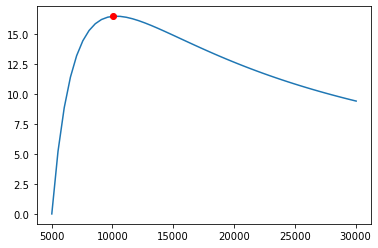

In [32]:
goal = lambda p : payoff_i(p, p2_data, 1)

print(f'At the outset, player 1 makes {goal(p1_data):5.2f}m EUR')

pp = np.linspace(c1, p1_data*3.0, 50)
yy = np.empty(pp.shape)
for ip,p in enumerate(pp): 
    yy[ip] = goal(p)
    
plt.plot(pp, yy); 
plt.plot(p1_data, goal(p1_data), 'or', label='Data'); 

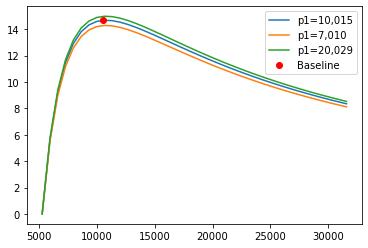

In [33]:
for p1_ in [p1_data, 0.7*p1_data, 2.0*p1_data]: 
    goal = lambda p : payoff_i(p1_, p, 2)
    
    pp = np.linspace(c2, p2_data*3.0, 40)
    yy = np.empty(pp.shape)
    for ip,p in enumerate(pp): 
        yy[ip] = goal(p)

    plt.plot(pp, yy, label=f'p1={p1_:,.0f}'); 

goal = lambda p : payoff_i(p1_data, p, 2)

plt.plot(p2_data, goal(p2_data), 'or', label='Baseline'); 
plt.legend(); 